# Pyroxy Demo: Surrogate Models for Expensive Functions

The `pyroxy` module provides a decorator that replaces expensive function calls with fast surrogate model predictions. The surrogate model is a machine learning model (typically Gaussian Process Regression) that learns from previous function evaluations.

## Key Concept

When you call a function decorated with `@Surrogate`:
1. **First calls**: The actual function runs to gather training data
2. **Subsequent calls**: The surrogate predicts the result
3. **Uncertainty check**: If prediction uncertainty is high, run the real function and retrain
4. **Otherwise**: Return the fast surrogate prediction

This is particularly useful for:
- Expensive numerical simulations
- Optimization problems with costly objective functions
- Parameter sweeps that call the same function many times
- Any function where evaluation time >> prediction time

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import time

from pycse.pyroxy import Surrogate, MaxCallsExceededException

# Suppress sklearn convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Set random seed for reproducibility
np.random.seed(42)

## Example 1: Basic Usage - Expensive Sine Function

Let's start with a simple example where we artificially make `sin(x)` expensive.

In [2]:
# Create a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)


# Define an expensive function
@Surrogate(model=gpr_model, tol=0.1, verbose=True)
def expensive_sin(X):
    """An artificially expensive sin function."""
    time.sleep(0.01)  # Simulate expensive computation
    return np.sin(X)


# Build training data using add() - this is the recommended approach
print("Building training data:")
X_train = np.array([[0.0], [1.0], [2.0], [3.0], [4.0], [5.0]])
start = time.time()
expensive_sin.add(X_train)  # Add all training data at once
train_time = time.time() - start
print(f"Training time: {train_time:.2f}s for {len(X_train)} points")

# Now test - subsequent calls should use surrogate
print("\nTesting surrogate predictions:")
X_test = np.array([[1.5], [2.5], [3.5], [4.5]])
start = time.time()
for x in X_test:
    result = expensive_sin(x)
    print(f"  X={x[0]:.1f}, result={result[0]:.4f}")
test_time = time.time() - start
print(f"\nTest time: {test_time:.2f}s for {len(X_test)} predictions")
print(f"Speedup: {(train_time / len(X_train)) / (test_time / len(X_test)):.1f}x")

Building training data:
Training time: 0.03s for 6 points

Testing surrogate predictions:
  X=1.5, result=0.9960
  X=2.5, result=0.5996
  X=3.5, result=-0.3523
  X=4.5, result=-0.9739

Test time: 0.00s for 4 predictions
Speedup: 48.4x


## Inspecting the Surrogate

Let's look at the surrogate's statistics and performance.

6 data points obtained.
        The model was fitted 1 times.
        The surrogate was successful 4 times.

        model score: 1.0
        Errors:
        MAE: 0.7931693867549048
        RMSE: 1.0069630433055814
        (tol = 0.1)

        


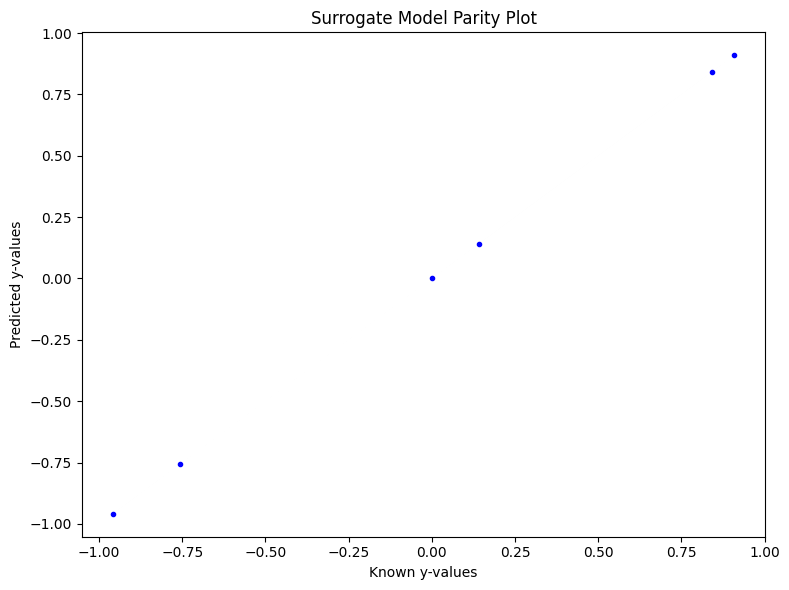

In [3]:
# Print statistics
print(expensive_sin)

# Visualize the surrogate fit
plt.figure(figsize=(8, 6))
expensive_sin.plot()
plt.title("Surrogate Model Parity Plot")
plt.tight_layout()
plt.show()

## Example 2: More Complex Function - Quadratic 2D Function

Let's use a 2D function to demonstrate multi-dimensional surrogates.

In [4]:
# Create a new model for 2D input
kernel_2d = C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0], (1e-2, 1e2))
gpr_2d = GaussianProcessRegressor(kernel=kernel_2d, n_restarts_optimizer=3, random_state=42)


@Surrogate(model=gpr_2d, tol=1.0, verbose=False)
def expensive_quadratic(X):
    """A 2D quadratic function."""
    time.sleep(0.01)  # Simulate expensive computation
    x = X[:, 0]
    y = X[:, 1]
    return x**2 + y**2


# Train with some initial points
print("Training the surrogate...")
X_train_2d = np.random.uniform(-3, 3, size=(20, 2))
start = time.time()
expensive_quadratic.add(X_train_2d)
train_time = time.time() - start
print(f"Training time: {train_time:.2f}s")

# Test the surrogate
print("\nTesting the surrogate...")
X_test_2d = np.random.uniform(-3, 3, size=(30, 2))
start = time.time()
results = []
for i in range(len(X_test_2d)):
    result = expensive_quadratic(X_test_2d[i : i + 1])
    results.append(result[0])
test_time = time.time() - start
print(f"Test time: {test_time:.2f}s")

# Statistics
print(f"\nFunction calls: {expensive_quadratic.func_calls}")
print(f"Surrogate uses: {expensive_quadratic.surrogate}")
if expensive_quadratic.surrogate > 0:
    print(f"Speedup: {(train_time / len(X_train_2d)) / (test_time / len(X_test_2d)):.1f}x")

Training the surrogate...
Training time: 0.03s

Testing the surrogate...
Test time: 0.00s

Function calls: 1
Surrogate uses: 30
Speedup: 41.4x


## Example 3: Using `test()` Method to Verify Accuracy

Use the `test()` method to verify surrogate accuracy at specific points.

In [5]:
kernel = C(1.0) * RBF(1.0)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)


@Surrogate(model=gpr, tol=0.1, verbose=False)
def cubic(X):
    """A cubic function."""
    return (X**3 - 2 * X**2 + X).flatten()


# Train the model
X_train = np.linspace(-2, 3, 15).reshape(-1, 1)
cubic.add(X_train)

# Test at various points
test_points = np.array([[0.5], [1.5], [2.5]])
print("Testing surrogate accuracy:")
for x in test_points:
    passed = cubic.test(x)
    print(f"  X={x[0]:.1f}, Test {'PASSED' if passed else 'FAILED'}")

print(f"\nTotal function calls (including tests): {cubic.func_calls}")

Testing surrogate accuracy:
  X=0.5, Test PASSED
  X=1.5, Test FAILED
  X=2.5, Test FAILED

Total function calls (including tests): 4


## Example 4: Maximum Function Calls Limit

In [6]:
kernel = C(1.0) * RBF(1.0)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)


# Limit to only 3 function calls
@Surrogate(model=gpr, tol=0.1, max_calls=3, verbose=True)
def limited_function(X):
    """Function with limited calls."""
    return np.exp(-(X**2)).flatten()


# Use up the allowed calls
X_points = np.array([[0.0], [1.0], [2.0]])
limited_function.add(X_points)
print(f"Function calls used: {limited_function.func_calls}/{limited_function.max_calls}")

# Try to exceed the limit by adding more data
try:
    limited_function.add(np.array([[3.0]]))
except MaxCallsExceededException as e:
    print(f"\nCaught expected exception: {e}")

# But surrogate predictions still work
print("\nSurrogate predictions (no function call needed):")
X_interp = np.array([[0.5], [1.5]])
for x in X_interp:
    result = limited_function(x)
    print(f"  X={x[0]:.2f}, result={result[0]:.4f}")
print(f"\nSurrogate was used {limited_function.surrogate} times")

Function calls used: 1/3

Surrogate predictions (no function call needed):
  X=0.50, result=0.6596
  X=1.50, result=0.1498

Surrogate was used 2 times


## Example 5: Using in Optimization

A practical use case: speeding up optimization of an expensive 1D function.

In [7]:
from scipy.optimize import minimize_scalar

# Create surrogate for a complicated 1D function
kernel = C(1.0) * RBF(1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, random_state=42)

call_count = {"actual": 0}  # Track actual function calls


def complicated_function_actual(X):
    """A complicated 1D function."""
    call_count["actual"] += 1
    time.sleep(0.001)  # Simulate expensive computation
    x = X.flatten()[0]
    return np.sin(x) * np.cos(x / 2) + 0.1 * x**2


# Build initial surrogate with some points
print("Building initial surrogate...")
X_init = np.linspace(-10, 10, 20).reshape(-1, 1)
y_init = np.array([complicated_function_actual(X.reshape(1, -1)) for X in X_init])
print(f"Initial training: {call_count['actual']} function calls")


# Now create surrogate
@Surrogate(model=gpr, tol=0.5, verbose=False)
def complicated_function(X):
    return complicated_function_actual(X)


# Initialize with training data
complicated_function.xtrain = X_init
complicated_function.ytrain = y_init
complicated_function.model.fit(X_init, y_init)
complicated_function.ntrain = 1
complicated_function.func_calls = call_count["actual"]

# Optimize using the surrogate
print("\nOptimizing with surrogate...")
initial_calls = call_count["actual"]


def objective(x):
    """Wrapper for optimizer (takes scalar)."""
    X = np.array([[x]])
    return complicated_function(X)[0]


result = minimize_scalar(objective, bounds=(-10, 10), method="bounded")

print("\nOptimization complete!")
print(f"Best solution: x={result.x:.4f}")
print(f"Best value: f(x)={result.fun:.4f}")
print("\nFunction call statistics:")
print(f"  Total actual calls: {call_count['actual']}")
print(f"  Calls during optimization: {call_count['actual'] - initial_calls}")
print(f"  Surrogate predictions: {complicated_function.surrogate}")

Building initial surrogate...
Initial training: 20 function calls

Optimizing with surrogate...

Optimization complete!
Best solution: x=-1.0523
Best value: f(x)=-0.6403

Function call statistics:
  Total actual calls: 20
  Calls during optimization: 0
  Surrogate predictions: 11


## Example 6: Saving and Loading Surrogates

In [8]:
import tempfile
import os

# Create a surrogate
kernel = C(1.0) * RBF(1.0)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)


@Surrogate(model=gpr, tol=0.1)
def my_function(X):
    return (X**2 + 2 * X + 1).flatten()


# Train it
X_train = np.linspace(-5, 5, 20).reshape(-1, 1)
my_function.add(X_train)

print("Original surrogate:")
print(f"  Function calls: {my_function.func_calls}")
print(f"  Training points: {len(my_function.xtrain)}")

# Save it
with tempfile.TemporaryDirectory() as tmpdir:
    save_path = os.path.join(tmpdir, "my_surrogate.pkl")
    my_function.dump(save_path)
    print(f"\nSaved to: {save_path}")

    # Load it
    loaded_surrogate = Surrogate.load(save_path)
    print("\nLoaded surrogate:")
    print(f"  Function calls: {loaded_surrogate.func_calls}")
    print(f"  Training points: {len(loaded_surrogate.xtrain)}")

    # Test the loaded surrogate
    X_test = np.array([[2.5], [-2.5]])
    print("\nTesting loaded surrogate:")
    for x in X_test:
        result = loaded_surrogate(x)
        expected = (x**2 + 2 * x + 1)[0]
        print(f"  X={x[0]:.1f}, predicted={result[0]:.2f}, expected={expected:.2f}")

Original surrogate:
  Function calls: 1
  Training points: 20

Saved to: /var/folders/gq/k1kgbl7n539_4dl1md8x3jt80000gn/T/tmpwmhs1t6n/my_surrogate.pkl

Loaded surrogate:
  Function calls: 1
  Training points: 20

Testing loaded surrogate:
  X=2.5, predicted=12.25, expected=12.25
  X=-2.5, predicted=2.25, expected=2.25


## Example 7: Visualizing Surrogate Performance

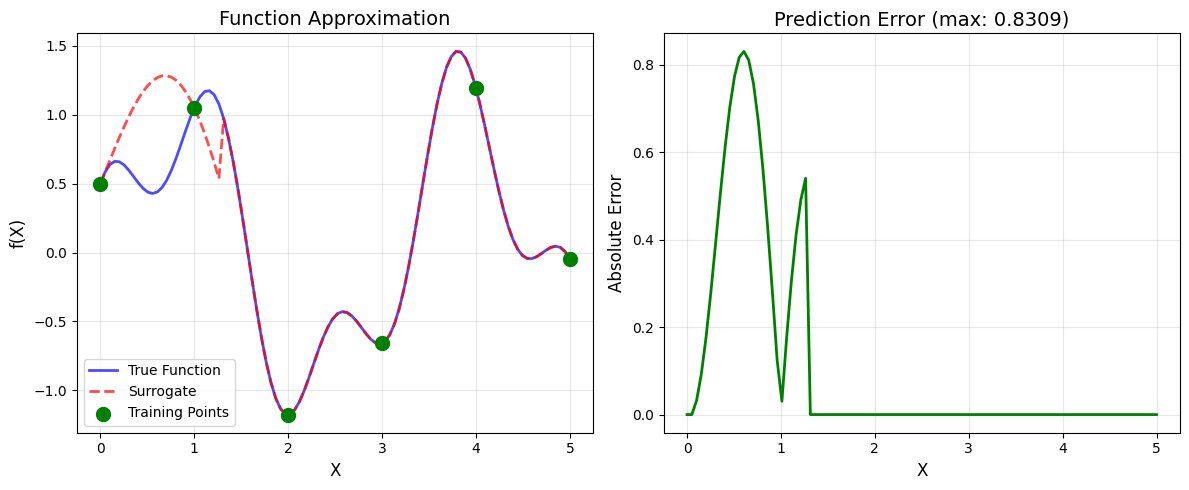


Statistics:
  Function calls: 75
  Surrogate predictions: 26
  Mean absolute error: 0.1080
  Max absolute error: 0.8309


In [9]:
# Create a simple function
kernel = C(1.0) * RBF(1.0)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)


@Surrogate(model=gpr, tol=0.15, verbose=False)
def wavy_function(X):
    """A wavy function."""
    return (np.sin(2 * X) + 0.5 * np.cos(5 * X)).flatten()


# Train with sparse data
X_train = np.array([[0], [1], [2], [3], [4], [5]])
wavy_function.add(X_train)

# Test on dense grid
X_dense = np.linspace(0, 5, 100).reshape(-1, 1)
y_true = np.sin(2 * X_dense) + 0.5 * np.cos(5 * X_dense)
y_pred = []
for x in X_dense:
    y_pred.append(wavy_function(x).flatten()[0])
y_pred = np.array(y_pred)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(X_dense, y_true.flatten(), "b-", label="True Function", alpha=0.7, linewidth=2)
plt.plot(X_dense, y_pred, "r--", label="Surrogate", alpha=0.7, linewidth=2)
plt.scatter(
    X_train,
    np.sin(2 * X_train) + 0.5 * np.cos(5 * X_train),
    color="green",
    s=100,
    zorder=5,
    label="Training Points",
)
plt.xlabel("X", fontsize=12)
plt.ylabel("f(X)", fontsize=12)
plt.legend(fontsize=10)
plt.title("Function Approximation", fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
errors = np.abs(y_true.flatten() - y_pred)
plt.plot(X_dense, errors, "g-", linewidth=2)
plt.xlabel("X", fontsize=12)
plt.ylabel("Absolute Error", fontsize=12)
plt.title(f"Prediction Error (max: {np.max(errors):.4f})", fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistics:")
print(f"  Function calls: {wavy_function.func_calls}")
print(f"  Surrogate predictions: {wavy_function.surrogate}")
print(f"  Mean absolute error: {np.mean(errors):.4f}")
print(f"  Max absolute error: {np.max(errors):.4f}")

## Summary

The `pyroxy` module provides efficient surrogate modeling:

### Key Features:
- **Automatic caching**: Expensive function results are cached and learned
- **Uncertainty-aware**: Only calls the real function when predictions are uncertain
- **Flexible models**: Works with any sklearn model that provides `predict(return_std=True)`
- **Easy to use**: Simple decorator syntax
- **Serialization**: Save and load trained surrogates
- **Safety limits**: `max_calls` prevents runaway function evaluations

### When to Use:
- **Expensive simulations**: Physics simulations, finite element analysis, etc.
- **Optimization**: When the objective function is costly to evaluate
- **Parameter sweeps**: Exploring parameter spaces efficiently
- **Real-time applications**: Where function evaluation time is critical

### Best Practices:
1. **Choose `tol` carefully**: Lower = more accurate but more function calls
2. **Initial training**: Use `add()` to build a good initial training set
3. **Model selection**: Gaussian Process works well for smooth functions
4. **Monitor statistics**: Check `func_calls` vs `surrogate` usage
5. **Test accuracy**: Use `test()` method to verify surrogate quality
6. **Save trained models**: Use `dump()` to avoid retraining
7. **Array shapes**: Always ensure X is 2D (use `X.reshape(-1, 1)` for 1D data)

### Performance Tips:
- For 100+ evaluations, surrogates can provide 10-100x speedup
- Initial training cost is amortized over many predictions
- Works best when function is smooth and relatively low-dimensional (< 10D)
- Use `add()` to provide initial training data for better coverage